# Machine Learning steps for the hospital readmission problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score, log_loss, auc, matthews_corrcoef, f1_score, fbeta_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.externals import joblib
from sklearn.dummy import DummyClassifier

sns.set()

In [2]:
# Loading the data and labels
with open('clean_data/df.pkl', 'rb') as f:
        df = pickle.load(f)
with open('clean_data/df_labels.pkl', 'rb') as f:
        df_labels = pickle.load(f)

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,level_4_diag_1_na,level_5_diag_1_na,level_2_diag_2_na,level_3_diag_2_na,level_4_diag_2_na,level_5_diag_2_na,level_2_diag_3_na,level_3_diag_3_na,level_4_diag_3_na,level_5_diag_3_na
0,2278392,8222157,3,1,0,0,0,1,1,0,...,0,0,1,1,1,1,1,1,1,1
1,149190,55629189,3,1,1,1,1,7,3,0,...,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,1,1,2,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,3,2,3,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,3,2,4,1,1,7,1,0,...,0,0,0,0,0,0,0,0,0,0


## How the values of `readmitted` variable are distributed?

In [4]:
df['readmitted'].value_counts().sort_index()

0    54864
1    11357
2    35545
Name: readmitted, dtype: int64

Since I am interested only in encounters with readmission within 30 days, I will label them as positive (1), and the rest as negative (0).

In [5]:
df['readmitted'] = (df['readmitted'] == 1).astype(int)
df['readmitted'].mean()

0.11159915885462728

The data set is highly inbalanced with the positive class representing only about 11% of all data. This presents a potential issue with training the classification models since the models will tend to perform better on predictive the negative class.

In [73]:
def data_split(df, y_col, to_drop=[], random_state=None, hold1_size=.1, hold2_size=.1, hold3_size=.1):
    """ Splits the dataframe into the train set and 3 hold-out sets.
    
    Drops columns to drop and the target variable from the DataFrame df. Then the rows are reshuffled and split into 4 groups: train set and 3 hold-out sets.
    
    Args:
        df: pandas DataFrame with the data.
        y_col: the name of the column with the target variable.
        to_drop: list of columns to drop from further analysis.
        random_state: the seed used by the random number generator.
        hold1_size: the size of the first hold-out set as a fraction of total.
        hold2_size: the size of the second hold-out set as a fraction of total.
        hold3_size: the size of the third hold-out set as a fraction of total.

    Returns:
        A tuple of length 9 containing train set, 3 hold-out sets split of inputs and a list of column labels.
    """
    df_filtered = df.drop(columns=to_drop)
    rows = list(df_filtered.index)
    if random_state is not None:
        random.seed(random_state)
    random.shuffle(rows)
    length = len(rows)
    train_rows = rows[:int(length*(1-(hold1_size + hold2_size + hold3_size)))]
    hold1_rows = rows[int(length*(1-(hold1_size + hold2_size + hold3_size))):int(length*(1-(hold2_size + hold3_size)))]
    hold2_rows = rows[int(length*(1-(hold1_size + hold3_size))):int(length*(1-hold3_size))]
    hold3_rows = rows[int(length*(1-hold3_size)):]
    X_train = df_filtered.drop(columns=[y_col]).iloc[train_rows].values
    y_train = df_filtered.loc[train_rows, y_col].values
    X_hold1 = df_filtered.drop(columns=[y_col]).iloc[hold1_rows].values
    y_hold1 = df_filtered.loc[hold1_rows, y_col].values
    X_hold2 = df_filtered.drop(columns=[y_col]).iloc[hold2_rows].values
    y_hold2 = df_filtered.loc[hold2_rows, y_col].values
    X_hold3 = df_filtered.drop(columns=[y_col]).iloc[hold3_rows].values
    y_hold3 = df_filtered.loc[hold3_rows, y_col].values
    cols = df_filtered.drop(columns=[y_col]).columns
    return X_train, y_train, X_hold1, y_hold1, X_hold2, y_hold2, X_hold3, y_hold3, cols

def test_model(X_train, y_train, X_valid, y_valid, clf, oob_score=False, test='Validation'):
    """ Performes a model diagnostics with the training and validation sets.
    
    Makes predictions using the provided model on the training set and validation sets. Plots confusion matrices for each set. 
    Returns the following diagnostic scores: precision score, recall score, F1 score, Fbeta score with beta=0.2, Mattews correlation coefficient,
    accuracy score, out-of-bag score.
    
    Args:
        X_train, y_train, X_valid, y_valid: trainig and validation sets.
        clf: classification model to be diagnosed.
        oob_score: boolean, indicating whether to include the out-of-bag scores calculated on the training data into the report.

    Returns:
        A pandas DataFrame with the diagnostic scores performed on the data sets.
    """
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_train, clf.predict(X_train)), cmap=plt.cm.Blues, square=True, annot=True, fmt='d', ax=ax1);
    ax1.set_title('Training data')
    sns.heatmap(confusion_matrix(y_valid, clf.predict(X_valid)), cmap=plt.cm.Blues, square=True, annot=True, fmt='d', ax=ax2);
    ax2.set_title('{} data'.format(test));
    plt.tight_layout();
    y_train_pred = clf.predict(X_train)
    y_valid_pred = clf.predict(X_valid)
    score_table = pd.DataFrame(columns=['training data', 'validation data'])
    score_table.loc['precision score', 'training data'] = precision_score(y_train, y_train_pred)
    score_table.loc['recall score', 'training data'] = recall_score(y_train, y_train_pred)
    score_table.loc['F1 score', 'training data'] = f1_score(y_train, y_train_pred)
    score_table.loc['Fbeta score', 'training data'] = fbeta_score(y_train, y_train_pred, beta=0.2)
    score_table.loc['Mattews correlation coefficient', 'training data'] = matthews_corrcoef(y_train, y_train_pred)
    score_table.loc['accuracy score', 'training data'] = accuracy_score(y_train, y_train_pred)
    score_table.loc['precision score', 'validation data'] = precision_score(y_valid, y_valid_pred)
    score_table.loc['recall score', 'validation data'] = recall_score(y_valid, y_valid_pred)
    score_table.loc['F1 score', 'validation data'] = f1_score(y_valid, y_valid_pred)
    score_table.loc['Fbeta score', 'validation data'] = fbeta_score(y_valid, y_valid_pred, beta=0.2)
    score_table.loc['Mattews correlation coefficient', 'validation data'] = matthews_corrcoef(y_valid, y_valid_pred)
    score_table.loc['accuracy score', 'validation data'] = accuracy_score(y_valid, y_valid_pred)
    if oob_score:
        score_table.loc['out of bag score', 'training data'] = clf.oob_score_
    return score_table

I will remove the columns that are not useful for prediction ('encounter_id', 'patient_nbr', 'payer_code'). For model tuning I will split data into a training set (70% of the data) and three hold-out sets (10% each). Hold-out set 1 will be used for tuning the hyperparameters. Hold-out set 2 will be used for validating the model. Hold-out set 3 will be used for the final model test.

In [7]:
X_train, y_train, X_hold1, y_hold1, X_hold2, y_hold2, X_hold3, y_hold3, cols = data_split(
    df=df, 
    y_col='readmitted',
    to_drop=['encounter_id', 'patient_nbr', 'payer_code'], 
    random_state=42,
    hold1_size=.1, 
    hold2_size=.1, 
    hold3_size=.1)
print(X_train.shape)
print(y_train.shape)

(71236, 83)
(71236,)


Concatenating the training set and the hold-out set 1 for the purposes of training models without tuning or for training models that were already tuned. 
## Dummy model
To establish a benchmark for the machine learning models, I will create a dummy classifier using stratified strategy.

,training data,validation data
precision score,0.113533,0.106594
recall score,0.112045,0.1036
F1 score,0.112784,0.105076
Fbeta score,0.113475,0.106476
Mattews correlation coefficient,0.001181,-0.0059004
accuracy score,0.801725,0.802496


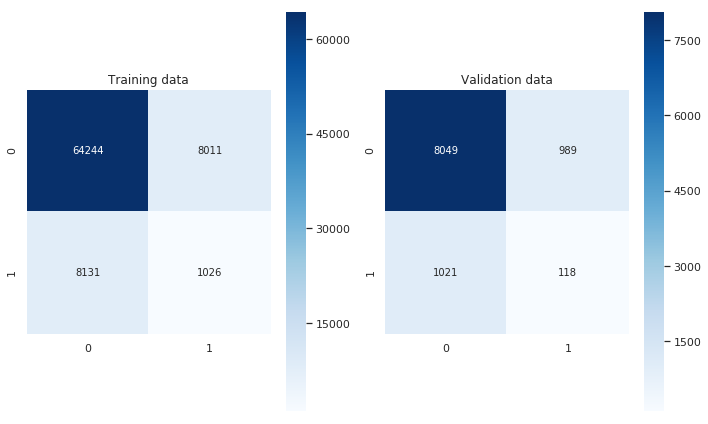

In [8]:
X_train_combined = np.concatenate((X_train, X_hold1))
y_train_combined = np.concatenate((y_train, y_hold1))
clf_dummy = DummyClassifier(random_state=42)
clf_dummy.fit(X_train_combined, y_train_combined)
test_model(X_train_combined, y_train_combined, X_hold2, y_hold2, clf_dummy)

## Random Forest model with the default hyperparameters
Next, I will train a Random Forest classification model with the default hyperparameters.

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,training data,validation data
precision score,0.999607,0.408163
recall score,0.833133,0.0175593
F1 score,0.908809,0.03367
Fbeta score,0.991983,0.219966
Mattews correlation coefficient,0.903056,0.0653594
accuracy score,0.981194,0.887197
out of bag score,0.866924,NaN


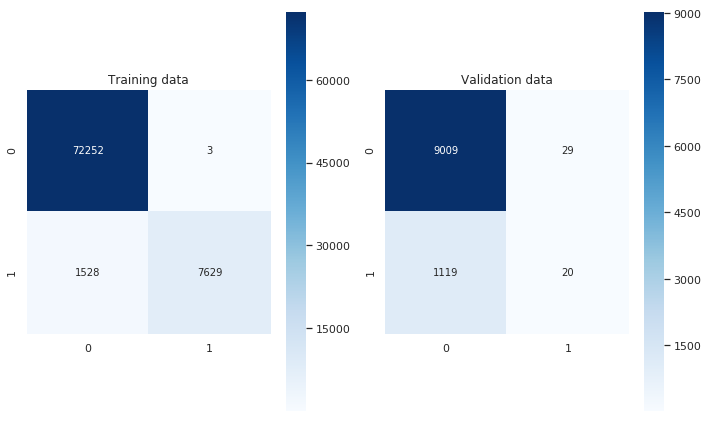

In [9]:
clf_RF = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)
clf_RF.fit(X_train_combined, y_train_combined)
test_model(X_train_combined, y_train_combined, X_hold2, y_hold2, clf_RF, oob_score=True)

The fitted model shows excellent scores on the training data, while performing much worse on the validation data. This is an indication of overfitting. To counteract it, the model needs to be tuned by adjusting the hyperparameters and validating on an unseen data set. Also the model works much better on predicting the negative class than predicting the positive class. This is likely due to the fact that the data is imbalanced towards the negative class. To account for that, I will be using the F1 score as a metrics for the hyperparameter tuning. Other available options are: precision, recall, F beta, mattews correlation coefficient. Optimizing the F1 score will help to maintain a balance between precision and recall.

## Undersampling to deal with imbalanced classes
There are several techniques for dealing with the imbalanced data set available in the imbalanced-learn package. First, I will utilize the random undersampling technique and will fit the Random Forest classifier on the resampled data.

In [10]:
rus = RandomUnderSampler(return_indices=True, random_state=42)
X_rus_combined, y_rus_combined, id_rus = rus.fit_sample(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)))
print(X_rus_combined.shape)
print(y_rus_combined.shape)

(18314, 83)
(18314,)


/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,training data,validation data
precision score,0.995212,0.146513
recall score,0.975975,0.457419
F1 score,0.985499,0.221938
Fbeta score,0.994458,0.150446
Mattews correlation coefficient,0.97146,0.0804156
accuracy score,0.985639,0.641053
out of bag score,0.54401,NaN


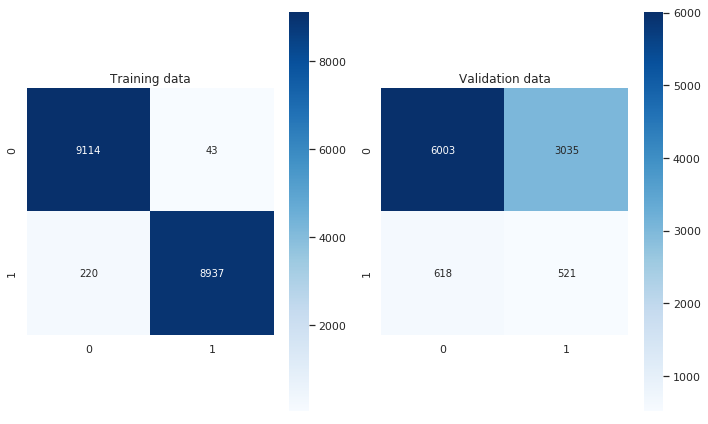

In [11]:
clf_rus = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)
clf_rus.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_rus, oob_score=True)

## Oversampling the training data
Next, I will try 2 oversampling methods: the Synthetic Minority Oversampling Technique (SMOTE) and the Adaptive Synthetic sampling (ADASYN). Both methods generate new samples by interpolation. Both methods are implemented in imbalanced-learn.

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,training data,validation data
precision score,0.999204,0.163752
recall score,0.990575,0.0904302
F1 score,0.994871,0.116516
Fbeta score,0.99887,0.1588
Mattews correlation coefficient,0.989823,0.0421985
accuracy score,0.994893,0.846517
out of bag score,0.857449,NaN


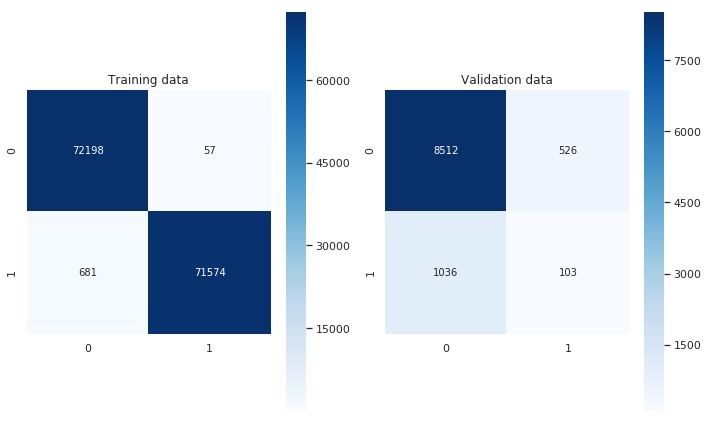

In [12]:
X_smote, y_smote = SMOTE(random_state=42).fit_resample(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)))
clf_smote = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)
clf_smote.fit(X_smote, y_smote)
test_model(X_smote, y_smote, X_hold2, y_hold2, clf_smote, oob_score=True)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,training data,validation data
precision score,0.998951,0.149547
recall score,0.989839,0.0869183
F1 score,0.994374,0.109939
Fbeta score,0.998597,0.145514
Mattews correlation coefficient,0.98885,0.0314815
accuracy score,0.994404,0.842488
out of bag score,0.854041,NaN


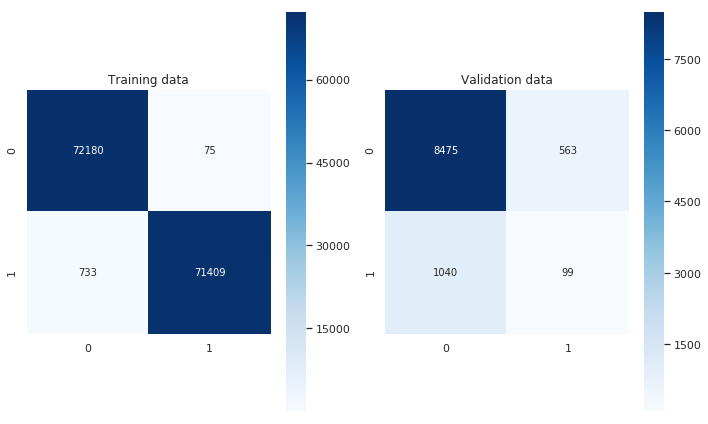

In [13]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_resample(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)))
clf_adasyn = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)
clf_adasyn.fit(X_adasyn, y_adasyn)
test_model(X_adasyn, y_adasyn, X_hold2, y_hold2, clf_adasyn, oob_score=True)

Out of 3 methods for dealing with the imbalanced data set tried: the random undersampling worked best with the F1 score of 0.22. This is double of the F1 scores produced by the oversampling methods (both produced the F1 scores of about 0.11). All future model training will be performed on the random undersampled data.

## Optimizing Random Forest classification for recall
To tune the Random Forest classification, I will create a DataFrame with the hyperparameter combinations and calculated model performance metrics. This will allow for easy selection of the hyperparameters depending on the performance metrics of interest.

In [14]:
rus = RandomUnderSampler(return_indices=True, random_state=42)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)

In [15]:
max_depths = [2, 5, 10, 20, 40, None]
min_samples_splits = [2, 3, 5, 7, 10, 50]
n_estimators_range = [2, 5, 10, 20, 40, 60, 100]
max_features_range = [2, 5, 7, 10, 15, 20, 25, 30]
def tune_RF(X_train, y_train, X_valid, y_valid, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42):
    """ Trains the Random Forest classification with the specified ranges of hyperparameters.
    
    Trains the model with the various combination of the hyperparameters provided as ranges. Outputs the pandas DataFrame with the performance metrics
    for each combination of the hyperparameters. This DataFrame will be useful for selecting the hyperparameters for the model.
    
    Args:
        X_train, y_train, X_valid, y_valid: trainig and validation sets.
        n_estimators_range, max_depths, min_samples_splits, max_features_range: lists with the hyperparameters for the Random Forest classification.
        beta: beta parameter for the Fbeta score.
        random_state: the seed used by the random number generator.

    Returns:
        A pandas DataFrame with the diagnostic scores for each of the hyperparameter combinations.
    """
    score_table = pd.DataFrame(columns = ['n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'f1_score', 'Fbeta_score', 'precision_score', 'recall_score', 'matthews_corrcoef'])
    i = 0
    for n_estimators in n_estimators_range:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for max_features in max_features_range:
                    clf = RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           max_features=max_features,
                                           n_jobs=-1,
                                           oob_score=True,
                                           random_state=42)
                    clf.fit(X_train, y_train)
                    score_table.loc[i, 'n_estimators'] = n_estimators
                    score_table.loc[i, 'max_features'] = max_features
                    score_table.loc[i, 'max_depth'] = max_depth
                    score_table.loc[i, 'min_samples_split'] = min_samples_split
                    score_table.loc[i, 'f1_score'] = f1_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'Fbeta_score'] = fbeta_score(y_valid, clf.predict(X_valid), beta=beta)
                    score_table.loc[i, 'precision_score'] = precision_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'recall_score'] = recall_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'oob score'] = clf.oob_score_
                    i += 1

    return score_table

In [16]:
%%capture
RF_score_table = tune_RF(X_rus, y_rus, X_hold1, y_hold1, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42)

Next, I will select the rows with the best recall score.

In [17]:
RF_score_table.loc[RF_score_table.recall_score == np.max(RF_score_table.recall_score)]

,n_estimators,max_features,max_depth,min_samples_split,f1_score,Fbeta_score,precision_score,recall_score,matthews_corrcoef,oob score
871,20.0,30.0,2.0,2.0,0.249353,0.157337,0.152643,0.680494,0.130354,0.592223
879,20.0,30.0,2.0,3.0,0.249353,0.157337,0.152643,0.680494,0.130354,0.592223
887,20.0,30.0,2.0,5.0,0.249353,0.157337,0.152643,0.680494,0.130354,0.592223
895,20.0,30.0,2.0,7.0,0.249353,0.157337,0.152643,0.680494,0.130354,0.592223
903,20.0,30.0,2.0,10.0,0.249353,0.157337,0.152643,0.680494,0.130354,0.592223
911,20.0,30.0,2.0,50.0,0.249353,0.157337,0.152643,0.680494,0.130354,0.592223


/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,training data,validation data
precision score,0.605574,0.160821
recall score,0.609807,0.61194
F1 score,0.607683,0.254705
Fbeta score,0.605736,0.165514
Mattews correlation coefficient,0.212629,0.133591
accuracy score,0.606312,0.599194
out of bag score,0.587692,NaN


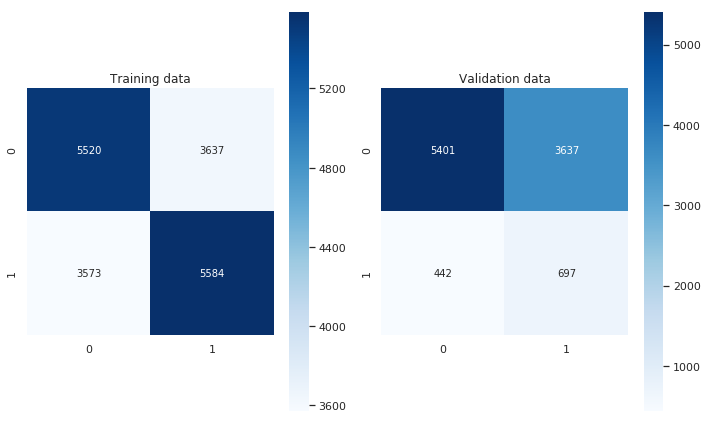

In [18]:
clf_RF_recall = RandomForestClassifier(
    n_estimators=10,
    max_depth=2,
    min_samples_split=2,
    max_features=30,
    n_jobs=-1,
    oob_score=True,
    random_state=42)
clf_RF_recall.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_RF_recall, oob_score=True)

## Optimizing Random Forest classification for precision

In [19]:
RF_score_table.loc[RF_score_table.precision_score == np.max(RF_score_table.precision_score)]

,n_estimators,max_features,max_depth,min_samples_split,f1_score,Fbeta_score,precision_score,recall_score,matthews_corrcoef,oob score
934,20.0,25.0,5.0,5.0,0.266331,0.175491,0.170641,0.606355,0.152533,0.605184


,training data,validation data
precision score,0.73238,0.165119
recall score,0.710385,0.5777
F1 score,0.721215,0.256831
Fbeta score,0.731509,0.169783
Mattews correlation coefficient,0.451006,0.135373
accuracy score,0.725401,0.625823
out of bag score,0.604401,NaN


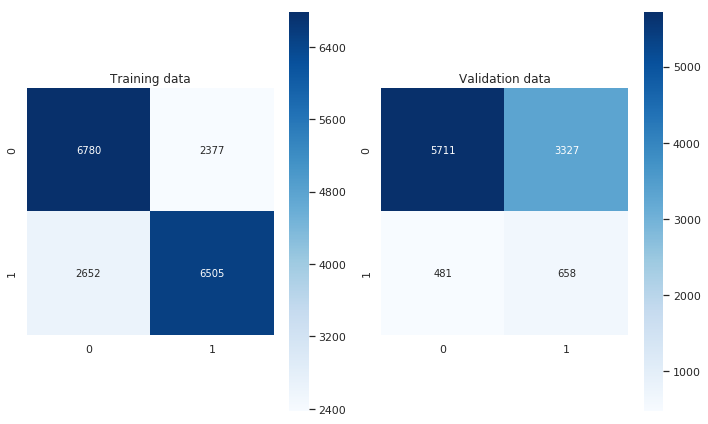

In [20]:
clf_RF_precision = RandomForestClassifier(
    n_estimators=40,
    max_depth=10,
    min_samples_split=7,
    max_features=10,
    n_jobs=-1,
    oob_score=True,
    random_state=42)
clf_RF_precision.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_RF_precision, oob_score=True)

## Optimizing Random Forest classification for F1 score

In [21]:
RF_score_table.loc[RF_score_table.f1_score == np.max(RF_score_table.f1_score)]

,n_estimators,max_features,max_depth,min_samples_split,f1_score,Fbeta_score,precision_score,recall_score,matthews_corrcoef,oob score
934,20.0,25.0,5.0,5.0,0.266331,0.175491,0.170641,0.606355,0.152533,0.605184


/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,training data,validation data
precision score,0.628385,0.164756
recall score,0.600524,0.580334
F1 score,0.614139,0.256649
Fbeta score,0.627266,0.169422
Mattews correlation coefficient,0.245628,0.135198
accuracy score,0.622693,0.623759
out of bag score,0.607896,NaN


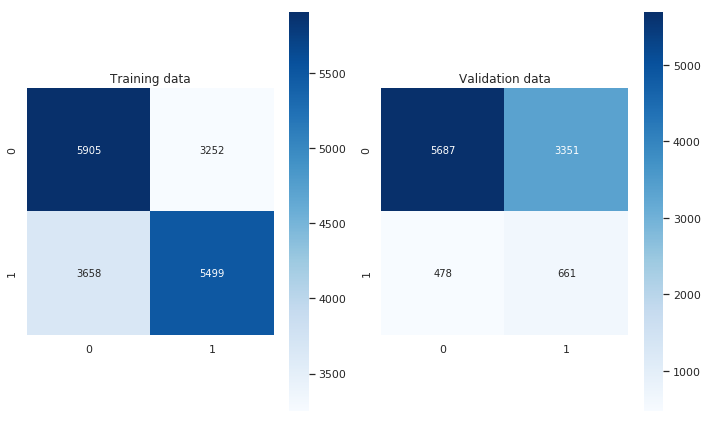

In [22]:
clf_RF_F1 = RandomForestClassifier(
    n_estimators=20,
    max_depth=5,
    min_samples_split=5,
    max_features=25,
    n_jobs=-1,
    oob_score=True,
    random_state=42)
clf_RF_F1.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_RF_F1, oob_score=True)

## Optimizing for Random Forest classification for Fbeta score with beta=0.2

In [23]:
RF_score_table.loc[RF_score_table.Fbeta_score == np.max(RF_score_table.Fbeta_score)]

,n_estimators,max_features,max_depth,min_samples_split,f1_score,Fbeta_score,precision_score,recall_score,matthews_corrcoef,oob score
934,20.0,25.0,5.0,5.0,0.266331,0.175491,0.170641,0.606355,0.152533,0.605184


,training data,validation data
precision score,0.73238,0.165119
recall score,0.710385,0.5777
F1 score,0.721215,0.256831
Fbeta score,0.731509,0.169783
Mattews correlation coefficient,0.451006,0.135373
accuracy score,0.725401,0.625823
out of bag score,0.604401,NaN


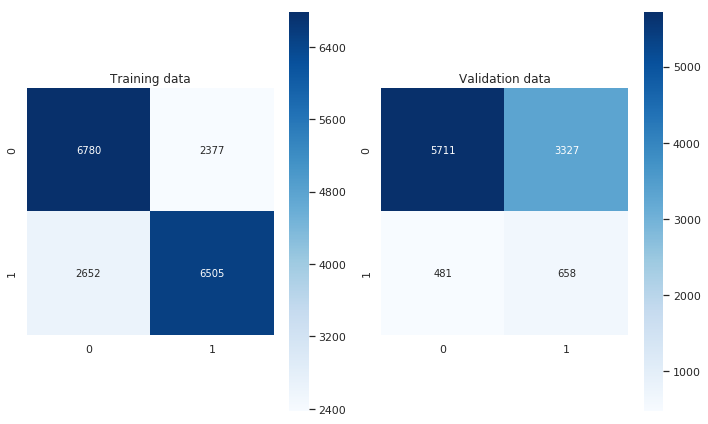

In [24]:
clf_RF_Fbeta = RandomForestClassifier(
    n_estimators=40,
    max_depth=10,
    min_samples_split=7,
    max_features=10,
    n_jobs=-1,
    oob_score=True,
    random_state=42)
clf_RF_Fbeta.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_RF_Fbeta, oob_score=True)

Random Forest classifiers trained show similar performance metrics. The overfitting is reduced in comparison with the model trained with the default hyperparameters, but the overfitting is still an issue here.

## Training Logistic Regression
Since logistic regression offers regularization as a way to deal with overfitting and make models more generalizable, I will train logistic regression next. Before doing so I will scale the data to make the ranges of features more similar.

In [25]:
scaler = MinMaxScaler()
scaler.fit(X_rus)
X_rus_scaled = scaler.transform(X_rus)
X_hold1_scaled = scaler.transform(X_hold1)
X_hold2_scaled = scaler.transform(X_hold2)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


I will use recursive feature elimination (RFE) available at scikit-learn to select the features most useful for training the logistic regression. 

In [26]:
logreg = LogisticRegression(penalty='l2', solver='newton-cg', C=10, multi_class='multinomial', random_state=42, n_jobs=-1)
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_rus_scaled, y_rus)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False False False False False False  True
  True  True False False False  True False False False False False  True
 False False False False False False False  True  True False  True False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True False False False  True
  True False  True  True  True False False False False False False False
 False False False False False False False False False False False]
[36 53  5 18  1 17 13 35 29 24 32  1  1  1 41 58 12  1 30 28  9  2 20  1
  4 64 33 40 21  7 14  1  1 63  1 22  8  3 62 61 60 50 10 44 59 39  6 19
 34 46  1  1  1  1  1  1 16 11 23  1  1 25  1  1  1 55 27 37 54 15 26 52
 45 56 57 31 38 47 42 43 48 49 51]


In [27]:
cols[rfe.support_]

Index(['discharge_disposition_id', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'chlorpropamide', 'acarbose',
       'miglitol', 'tolazamide', 'simple_diag_1', 'simple_diag_2',
       'simple_diag_3', 'level_2_diag_1', 'level_3_diag_1', 'level_4_diag_1',
       'level_4_diag_2', 'level_5_diag_2', 'level_3_diag_3', 'level_4_diag_3',
       'level_5_diag_3'],
      dtype='object')

,training data,validation data
precision score,0.627014,0.171272
recall score,0.480184,0.467954
F1 score,0.543863,0.250765
Fbeta score,0.619725,0.175553
Mattews correlation coefficient,0.200105,0.124949
accuracy score,0.597271,0.687039


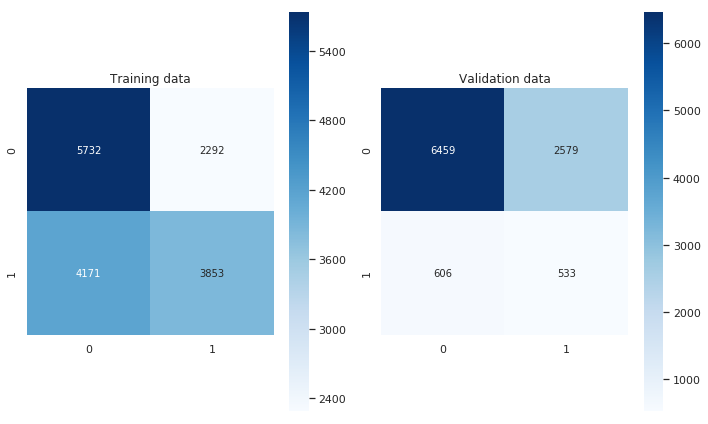

In [28]:
logreg = LogisticRegression(penalty='l2', solver='newton-cg', C=10, multi_class='multinomial', random_state=42, n_jobs=-1)
logreg.fit(X_rus_scaled[:, rfe.support_], y_rus)
test_model(X_rus_scaled[:, rfe.support_], y_rus, X_hold2_scaled[:, rfe.support_], y_hold2, logreg, oob_score=False)

I will tune logistic regression by training the model on the range of C parameter, I will alsy try l1 and l2 regularizations.

In [29]:
%%capture
C_param_range = [0.001,0.01,0.1,1,10,100]
penalty_range = ['l1', 'l2']

def tune_logreg(X_train, y_train, X_valid, y_valid, rfe, C_param_range, penalty_range, beta=0.2, random_state=42):
    score_table = pd.DataFrame(columns = ['C_parameter', 'penalty', 'Fbeta_score', 'precision_score', 'recall_score', 'f1_score', 'matthews_corrcoef'])
    ind = 0
    for C_param in C_param_range:
        for penalty in penalty_range:
            if penalty == 'l2':
                solver = 'newton-cg'
            elif penalty == 'l1':
                solver = 'liblinear'
            logreg = LogisticRegression(penalty=penalty, solver=solver, C=C_param, max_iter=1000, random_state=random_state, n_jobs=-1)
            logreg.fit(X_train[:, rfe.support_], y_train)
            y_pred = logreg.predict(X_valid[:, rfe.support_])
            # Saving accuracy score in table
            score_table.loc[ind, 'C_parameter'] = C_param
            score_table.loc[ind, 'penalty'] = penalty
            score_table.loc[ind, 'Fbeta_score'] = fbeta_score(y_valid, y_pred, beta=beta)
            score_table.loc[ind, 'precision_score'] = precision_score(y_valid, y_pred)
            score_table.loc[ind, 'recall_score'] = recall_score(y_valid, y_pred)
            score_table.loc[ind, 'f1_score'] = f1_score(y_valid, y_pred)
            score_table.loc[ind, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, y_pred)    
            ind += 1
    return score_table

logreg_score_table = tune_logreg(X_rus_scaled, y_rus, X_hold1_scaled, y_hold1, rfe, C_param_range, penalty_range, beta=0.2, random_state=42)
logreg_score_table.head()

In [30]:
logreg_score_table.loc[logreg_score_table.f1_score == np.max(logreg_score_table.f1_score)]

,C_parameter,penalty,Fbeta_score,precision_score,recall_score,f1_score,matthews_corrcoef
7,1,l2,0.182039,0.177585,0.488085,0.260419,0.139847


The model with the best F1 score (0.26) has the C parameter of 1 and uses l2 penalty. These parameters will be used for training the model on the combined training set and hold-out set 1. 

In [31]:
scaler = MinMaxScaler()
scaler.fit(X_rus_combined)
X_rus_combined_scaled = scaler.transform(X_rus_combined)
X_hold2_combined_scaled = scaler.transform(X_hold2)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,training data,validation data
precision score,0.628637,0.169854
recall score,0.478978,0.460053
F1 score,0.543697,0.248106
Fbeta score,0.621172,0.174077
Mattews correlation coefficient,0.201828,0.121201
accuracy score,0.598012,0.687924


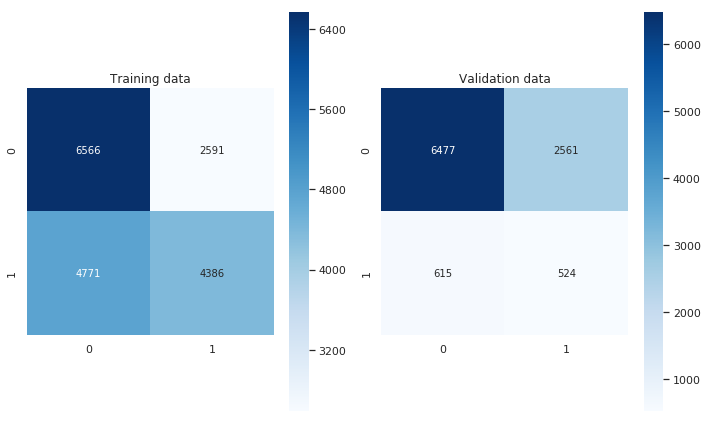

In [32]:
logreg = LogisticRegression(penalty='l2', solver='liblinear', C=1, max_iter=1000, random_state=42)
logreg.fit(X_rus_combined_scaled[:, rfe.support_], y_rus_combined)
test_model(X_rus_combined_scaled[:, rfe.support_], y_rus_combined, X_hold2_combined_scaled[:, rfe.support_], y_hold2, logreg)

Tuned logistic regression model shows minimal overfitting and improved F1 score (0.25) compared to the Random Forest classification models.

In [33]:
logreg.coef_

array([[ 1.02305614,  0.27145127,  1.41829359,  5.87312714,  0.88985658,
         0.09248417,  0.06357285, -0.19534553, -0.17778418, -0.07735807,
        -0.04501447,  0.26743869, -0.23660592,  0.95190948, -0.77094919,
         0.20714231, -0.26553595, -0.99763495,  0.23861004,  0.29491345]])

## Optimizing logistic regression with elastic net
Since logistic regression classifier available in sklearn does not allow for regularization with elastic net, I will use SGDClassifier (stochastic gradient descent classifier) for tuning logistic regression with all features.

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


,training data,validation data
precision score,0.619023,0.163776
recall score,0.527356,0.505707
F1 score,0.569525,0.247423
Fbeta score,0.614912,0.168149
Mattews correlation coefficient,0.205056,0.11953
accuracy score,0.601398,0.655694


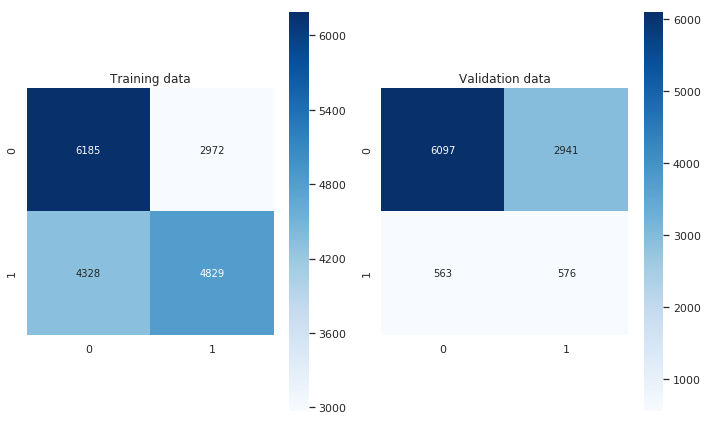

In [34]:
clf = SGDClassifier(loss='log', max_iter=1000, random_state=42)
clf.fit(X_rus_combined_scaled, y_rus_combined)
test_model(X_rus_combined_scaled, y_rus_combined, X_hold2_combined_scaled, y_hold2, clf)

In [35]:
%%capture
alpha_range = [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]
penalty_range = ['l1', 'l2', 'elasticnet']
l1_ratio_range = [.1, .3, .5, .7, .9]

def tune_SGD(X_train, y_train, X_valid, y_valid, alpha_range, penalty_range, l1_ratio_range, beta=0.2, random_state=42):
    score_table = pd.DataFrame(columns = ['alpha', 'penalty', 'l1_ratio', 'F1_score', 'Fbeta_score', 'precision_score', 'recall_score', 'matthews_corrcoef'])
    ind = 0
    for alpha in alpha_range:
        for penalty in penalty_range:
            for l1_ratio in l1_ratio_range:
                if penalty != 'elasticnet' and l1_ratio > l1_ratio_range[0]:
                    continue
                elif penalty == 'elasticnet':
                    clf = SGDClassifier(loss='log',
                              alpha=alpha, 
                              penalty=penalty, 
                              l1_ratio=l1_ratio, 
                              random_state=random_state, 
                              max_iter=1000,
                              tol=1e-3,
                              n_jobs=-1)
                else:
                    clf = SGDClassifier(loss='log', 
                              alpha=alpha, 
                              penalty=penalty, 
                              max_iter=1000,
                              tol=1e-3,
                              random_state=random_state, 
                              n_jobs=-1)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_valid)
                # Saving accuracy score in table
                score_table.loc[ind, 'alpha'] = alpha
                score_table.loc[ind, 'penalty'] = penalty
                score_table.loc[ind, 'l1_ratio'] = l1_ratio
                score_table.loc[ind, 'F1_score'] = f1_score(y_valid, y_pred)
                score_table.loc[ind, 'Fbeta_score'] = fbeta_score(y_valid, y_pred, beta=beta)
                score_table.loc[ind, 'precision_score'] = precision_score(y_valid, y_pred)
                score_table.loc[ind, 'recall_score'] = recall_score(y_valid, y_pred)
                score_table.loc[ind, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, y_pred)    
                ind += 1
    return score_table

SGD_score_table = tune_SGD(X_rus_scaled, y_rus, X_hold1_scaled, y_hold1, alpha_range, penalty_range, l1_ratio_range, beta=0.2, random_state=42)

In [36]:
SGD_score_table.loc[SGD_score_table.F1_score == np.max(SGD_score_table.F1_score)]

,alpha,penalty,l1_ratio,F1_score,Fbeta_score,precision_score,recall_score,matthews_corrcoef
17,0.001,elasticnet,0.3,0.247092,0.19525,0.191895,0.346867,0.128548


The model with the best F1 score has alpha parameter of 0.001, uses elastic net for penalty with the l1 ratio of 0.3. I will use these parameters for training the model on the combined training set and hold-out set 1.

,training data,validation data
precision score,0.615742,0.165308
recall score,0.521131,0.516242
F1 score,0.5645,0.250426
Fbeta score,0.611472,0.169746
Mattews correlation coefficient,0.19827,0.124132
accuracy score,0.597958,0.654122


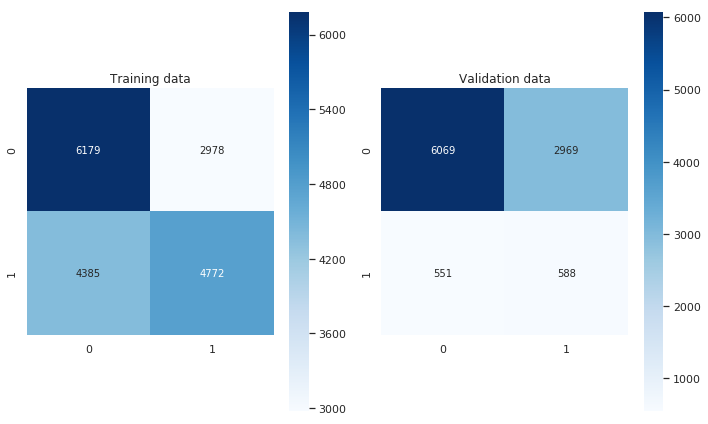

In [37]:
clf_elasticnet = SGDClassifier(
          loss='log', 
          alpha=0.001, 
          penalty='elasticnet', 
          l1_ratio=.3,
          max_iter=1000,
          tol=1e-3,
          random_state=42, 
          n_jobs=-1)
clf_elasticnet.fit(X_rus_combined_scaled, y_rus_combined)
test_model(X_rus_combined_scaled, y_rus_combined, X_hold2_combined_scaled, y_hold2, clf_elasticnet)

The F1 score obtained with elastic net regularization is the best so far (0.25). 

## Training AdaBoost

Boosting offers an excellent way to improve a classifier performance. Here, I will use AdaBoost and Gradient Boosting algorithms.

,training data,validation data
precision score,1,0.125242
recall score,1,0.680421
F1 score,1,0.211546
Fbeta score,1,0.1293
Mattews correlation coefficient,1,0.0526355
accuracy score,1,0.432347


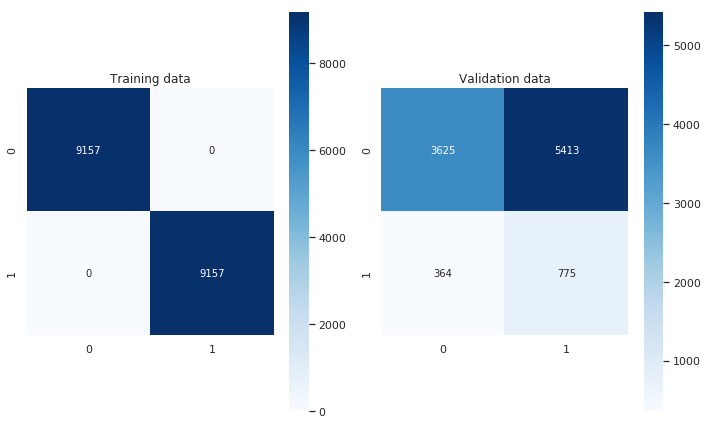

In [38]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier())
ada_clf.fit(X_rus_combined_scaled, y_rus_combined)
test_model(X_rus_combined_scaled, y_rus_combined, X_hold2, y_hold2, ada_clf)

Training on the AdaBoost with the default parameters led to extreme overfitting. To deal with that I will tune AdaBoost by otpimizing hyperparameters.

In [39]:
max_depths = [2, 5, 10, 20, 40, None]
min_samples_splits = [2, 3, 5, 7, 10, 50]
n_estimators_range = [2, 5, 10, 20, 40, 60, 100]

ada_score_table = pd.DataFrame(columns = ['n_estimators', 'max_depth', 'min_samples_split', 'Fbeta_score', 'precision_score', 'recall_score', 'F1_score', 'matthews_corrcoef'])
i = 0
for n_estimators in n_estimators_range:
    for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
            ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                               min_samples_split=min_samples_split),
                                      n_estimators=n_estimators,
                                      random_state=42)
            ada_clf.fit(X_rus, y_rus)
            ada_score_table.loc[i, 'n_estimators'] = n_estimators
            ada_score_table.loc[i, 'max_depth'] = max_depth
            ada_score_table.loc[i, 'min_samples_split'] = min_samples_split
            ada_score_table.loc[i, 'F1_score'] = f1_score(y_hold1, ada_clf.predict(X_hold1))
            ada_score_table.loc[i, 'Fbeta_score'] = fbeta_score(y_hold1, ada_clf.predict(X_hold1), beta=0.2)
            ada_score_table.loc[i, 'precision_score'] = precision_score(y_hold1, ada_clf.predict(X_hold1))
            ada_score_table.loc[i, 'recall_score'] = recall_score(y_hold1, ada_clf.predict(X_hold1))
            ada_score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_hold1, ada_clf.predict(X_hold1))
            i += 1

In [40]:
ada_score_table.loc[ada_score_table.F1_score == np.max(ada_score_table.F1_score)]

,n_estimators,max_depth,min_samples_split,Fbeta_score,precision_score,recall_score,F1_score,matthews_corrcoef
72,10,2,2,0.172415,0.167508,0.644307,0.26589,0.154543
73,10,2,3,0.172415,0.167508,0.644307,0.26589,0.154543
74,10,2,5,0.172415,0.167508,0.644307,0.26589,0.154543
75,10,2,7,0.172415,0.167508,0.644307,0.26589,0.154543
76,10,2,10,0.172415,0.167508,0.644307,0.26589,0.154543
77,10,2,50,0.172415,0.167508,0.644307,0.26589,0.154543


,training data,validation data
precision score,0.620735,0.168523
recall score,0.619854,0.624232
F1 score,0.620294,0.265398
Fbeta score,0.620701,0.173392
Mattews correlation coefficient,0.241127,0.151087
accuracy score,0.620564,0.613246


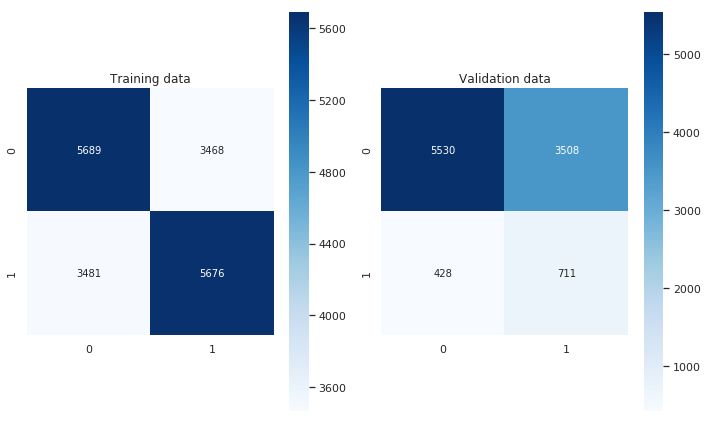

In [41]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=2,
    min_samples_split=2),
    n_estimators=10,
    random_state=42)
ada_clf.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, ada_clf)

The tuned AdaBoost has an F1 score of 0.26, which is the best so far.

## Training Gradient Boosting classifier

,training data,validation data
precision score,0.643207,0.171534
recall score,0.631757,0.613696
F1 score,0.63743,0.268124
Fbeta score,0.642759,0.176423
Mattews correlation coefficient,0.281359,0.154526
accuracy score,0.640657,0.625037


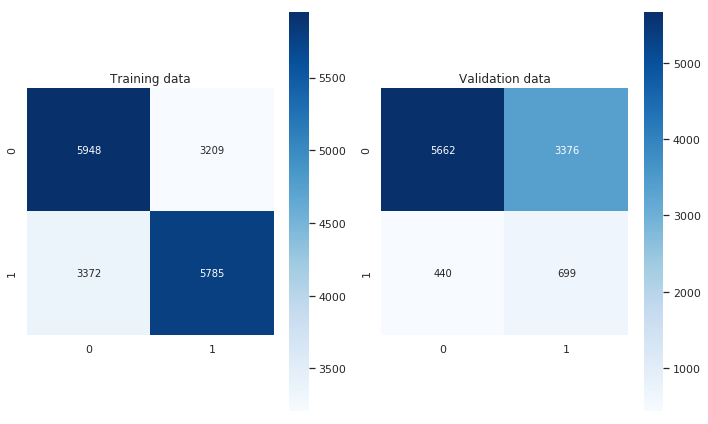

In [42]:
gbc = GradientBoostingClassifier()
gbc.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, gbc)

In [43]:
max_depths = [2, 5, 10, 20, 40, None]
min_samples_splits = [2, 3, 5, 7, 10, 50]
n_estimators_range = [2, 5, 10, 20, 40, 60, 100]
max_features_range = [2, 5, 7, 10, 15, 20, 25, 30]

def tune_GBC(X_train, y_train, X_valid, y_valid, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42):
    score_table = pd.DataFrame(columns = ['n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'Fbeta_score', 'precision_score', 'recall_score', 'F1_score', 'matthews_corrcoef'])
    i = 0
    for n_estimators in n_estimators_range:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for max_features in max_features_range:
                    clf = GradientBoostingClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        max_features=max_features,
                        random_state=random_state)
                    clf.fit(X_train, y_train)
                    score_table.loc[i, 'n_estimators'] = n_estimators
                    score_table.loc[i, 'max_features'] = max_features
                    score_table.loc[i, 'max_depth'] = max_depth
                    score_table.loc[i, 'min_samples_split'] = min_samples_split
                    score_table.loc[i, 'F1_score'] = f1_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'Fbeta_score'] = fbeta_score(y_valid, clf.predict(X_valid), beta=beta)
                    score_table.loc[i, 'precision_score'] = precision_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'recall_score'] = recall_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, clf.predict(X_valid))
                    i += 1

    return score_table

In [44]:
GBC_score_table = tune_GBC(X_rus, y_rus, X_hold1, y_hold1, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42)
GBC_score_table.loc[GBC_score_table.F1_score == np.max(GBC_score_table.F1_score)]

,n_estimators,max_features,max_depth,min_samples_split,Fbeta_score,precision_score,recall_score,F1_score,matthews_corrcoef
1733,100,20,2,2,0.182045,0.177116,0.598411,0.273332,0.162382
1741,100,20,2,3,0.182045,0.177116,0.598411,0.273332,0.162382
1749,100,20,2,5,0.182045,0.177116,0.598411,0.273332,0.162382
1757,100,20,2,7,0.182045,0.177116,0.598411,0.273332,0.162382


,training data,validation data
precision score,0.632876,0.172682
recall score,0.589058,0.583845
F1 score,0.610181,0.266533
Fbeta score,0.63107,0.17749
Mattews correlation coefficient,0.247947,0.150379
accuracy score,0.623676,0.640366


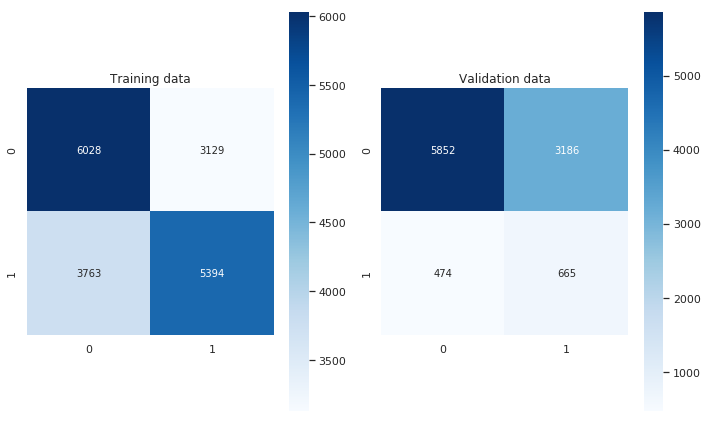

In [45]:
clf_gbc = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=2,
    min_samples_split=2,
    max_features=20,
    random_state=42)
clf_gbc.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_gbc)

The F1 score of the Gradient Boosting algorithm is 0.26, which is similar to the one obtained with the AdaBoost. 
## Tuning Random Forest using Out-of-Bag score
Next, I will tune the combined training set, first hold-out set and second hold-out set to have more data for the Random Forest training. I will use the out-of-bag score for evaluating the model.

In [46]:
X_train_combined2 = np.concatenate((X_train, X_hold1, X_hold2))
y_train_combined2 = np.concatenate((y_train, y_hold1, y_hold2))
print(X_train_combined2.shape)
print(y_train_combined2.shape)

(91589, 83)
(91589,)


In [47]:
rus = RandomUnderSampler(return_indices=True, random_state=42)
X_rus_combined2, y_rus_combined2, id_rus2 = rus.fit_resample(X_train_combined2, y_train_combined2)
print(X_rus_combined2.shape)
print(y_rus_combined2.shape)

(20592, 83)
(20592,)


In [48]:
max_depths = [2, 5, 10, 20, 40, None]
min_samples_splits = [2, 3, 5, 7, 10, 50]
n_estimators_range = [2, 5, 10, 20, 40, 60, 100]
max_features_range = [2, 5, 7, 10, 15, 20, 25, 30]
def tune_RF_OOB(X_train, y_train, n_estimators_range, max_depths, min_samples_splits, max_features_range, random_state=42):
    score_table = pd.DataFrame(columns = ['n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'oob_score'])
    i = 0
    for n_estimators in n_estimators_range:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for max_features in max_features_range:
                    clf = RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           max_features=max_features,
                                           n_jobs=-1,
                                           oob_score=True,
                                           random_state=random_state)
                    clf.fit(X_train, y_train)
                    score_table.loc[i, 'n_estimators'] = n_estimators
                    score_table.loc[i, 'max_features'] = max_features
                    score_table.loc[i, 'max_depth'] = max_depth
                    score_table.loc[i, 'min_samples_split'] = min_samples_split
                    score_table.loc[i, 'oob_score'] = clf.oob_score_
                    i += 1

    return score_table

In [49]:
%%capture
RF_OOB_score_table = tune_RF_OOB(X_rus_combined2, y_rus_combined2, n_estimators_range, max_depths, min_samples_splits, max_features_range, random_state=42)

In [50]:
RF_OOB_score_table.loc[RF_OOB_score_table.oob_score == np.max(RF_OOB_score_table.oob_score)]

,n_estimators,max_features,max_depth,min_samples_split,oob_score
1580,60,15,10,50,0.616744


In [51]:
clf_RF_oob = RandomForestClassifier(
    n_estimators=60,
    max_depth=10,
    min_samples_split=50,
    max_features=15,
    n_jobs=-1,
    oob_score=True,
    random_state=42)
clf_RF_oob.fit(X_rus_combined2, y_rus_combined2)
print(clf_RF_oob.oob_score_)

0.6167443667443667


In [52]:
RF_models_to_compare = [clf_RF, clf_smote, clf_rus, clf_adasyn, clf_RF_recall, clf_RF_precision, clf_RF_Fbeta, clf_RF_oob]
RF_model_labels = ['clf_RF', 'clf_smote', 'clf_rus', 'clf_adasyn', 'clf_RF_recall', 'clf_RF_precision', 'clf_RF_Fbeta', 'clf_RF_oob']
RF_oob_scores = [RF_model.oob_score_ for RF_model in RF_models_to_compare]
RF_oob_df = pd.DataFrame({'model':RF_model_labels, 'oob score':RF_oob_scores})
RF_oob_df

,model,oob score
0,clf_RF,0.866924
1,clf_smote,0.857449
2,clf_rus,0.544010
3,clf_adasyn,0.854041
4,clf_RF_recall,0.587692
5,clf_RF_precision,0.604401
6,clf_RF_Fbeta,0.604401
7,clf_RF_oob,0.616744


The out-of-bag scores vary a lot depending on the approach. The highest score was obtained with the dataset without treating for imbalanced data (clf_RF). In this case the out-of-bag score is hard to interpret since the accuracy score is meaningless for the imbalanced data. Comparatively high out-of-bag scores were produced by training on the oversampled data. These models did not generalize well and were eliminated. The next highest out-of-bag score is produced with the largest data set used for training (combined training and 2 hould-out sets). The improvement over other models is marginal. In addition, it is hard to comare this model with non-random forest models since there is no data left that can be used for validation.
## Fitting a model on Principal Components
Next, I will decrease the number of features used for training by applying principal component analysis (PCA). Exploratory data analysis showed that 3 principal components account for more than 99.99% of variance. Therefore using 3 principal components here. Gradient Boosting classifier is used here since it produced the best results so far on the data with all features.

In [53]:
pca = PCA(n_components=3)
X_train_combined_pcs = pca.fit_transform(X_rus_combined)
X_hold2_pcs = pca.transform(X_hold2)
X_hold3_pcs = pca.transform(X_hold3)

,training data,validation data
precision score,0.553356,0.124177
recall score,0.522114,0.496927
F1 score,0.537282,0.198701
Fbeta score,0.552086,0.127866
Mattews correlation coefficient,0.100849,0.0350193
accuracy score,0.550344,0.55144


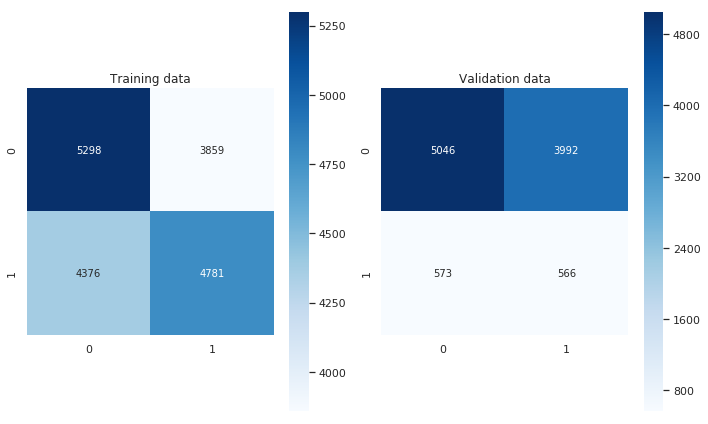

In [54]:
gbc_PCA = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=2,
    min_samples_split=2,
    random_state=42)
gbc_PCA.fit(X_train_combined_pcs, y_rus_combined)
test_model(X_train_combined_pcs, y_rus_combined, X_hold2_pcs, y_hold2, gbc_PCA)

The model trained on principal components (F1 score of 0.20) performed the worse that the Gradient Boosting model.
## Model comparison
For better comparison of model performances, I will plot the F1 scores for each model trained.

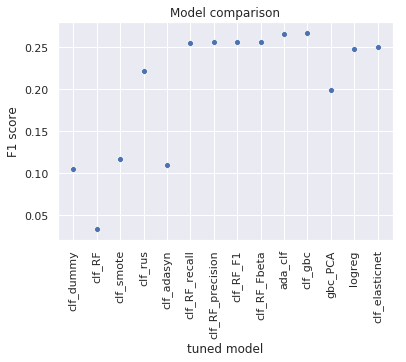

In [55]:
models_to_compare = [clf_dummy, clf_RF, clf_smote, clf_rus, clf_adasyn, clf_RF_recall, clf_RF_precision, clf_RF_F1, clf_RF_Fbeta, ada_clf, clf_gbc, gbc_PCA, logreg, clf_elasticnet]
model_labels = ['clf_dummy', 'clf_RF', 'clf_smote', 'clf_rus', 'clf_adasyn', 'clf_RF_recall', 'clf_RF_precision', 'clf_RF_F1', 'clf_RF_Fbeta', 'ada_clf', 'clf_gbc', 'gbc_PCA', 'logreg', 'clf_elasticnet']
F1_scores = [f1_score(y_hold2, clf_model.predict(X_hold2)) for clf_model in models_to_compare[:-3]]
F1_scores.append(f1_score(y_hold2, gbc_PCA.predict(X_hold2_pcs)))
F1_scores.append(f1_score(y_hold2, logreg.predict(X_hold2_combined_scaled[:, rfe.support_])))
F1_scores.append(f1_score(y_hold2, clf_elasticnet.predict(X_hold2_combined_scaled)))
F1_score = pd.DataFrame({'F1_score': F1_scores, 'model': models_to_compare, 'model_label': model_labels})
sns.scatterplot(data=F1_score, x='model_label', y='F1_score');
plt.xticks(rotation='vertical');
plt.xlabel('tuned model');
plt.ylabel(r'F1 score');
plt.title('Model comparison');

In [56]:
F1_score.loc[F1_score.F1_score == np.max(F1_score.F1_score)]

,F1_score,model,model_label
10,0.266533,([DecisionTreeRegressor(criterion='friedman_ms...,clf_gbc


,training data,validation data
precision score,0.632876,0.172682
recall score,0.589058,0.583845
F1 score,0.610181,0.266533
Fbeta score,0.63107,0.17749
Mattews correlation coefficient,0.247947,0.150379
accuracy score,0.623676,0.640366


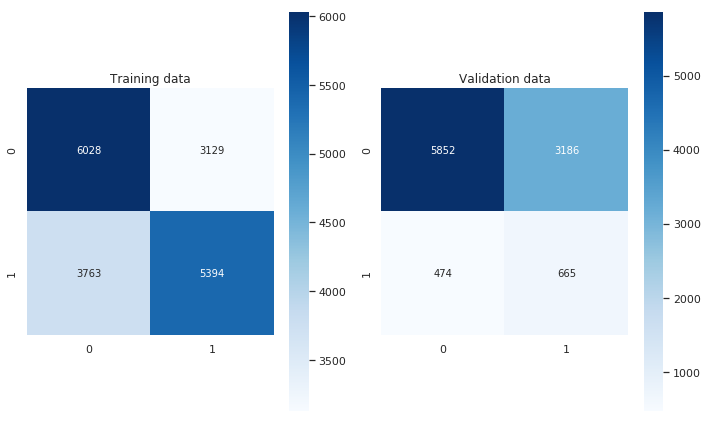

In [57]:
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_gbc)

The Gradient Boosting model is the best performing as judged by the F1 score.

## Testing on the final holdout set
Next, I will train a model on the data that includes the training set and 2 hold-out sets. This model will be tested on up to this point unused data set (hold-out set 3) to estimate how the model would generalize to new data.

,training data,validation data
precision score,0.63573,0.169391
recall score,0.566822,0.566447
F1 score,0.599302,0.260794
Fbeta score,0.632771,0.174085
Mattews correlation coefficient,0.24347,0.155938
accuracy score,0.621018,0.665226


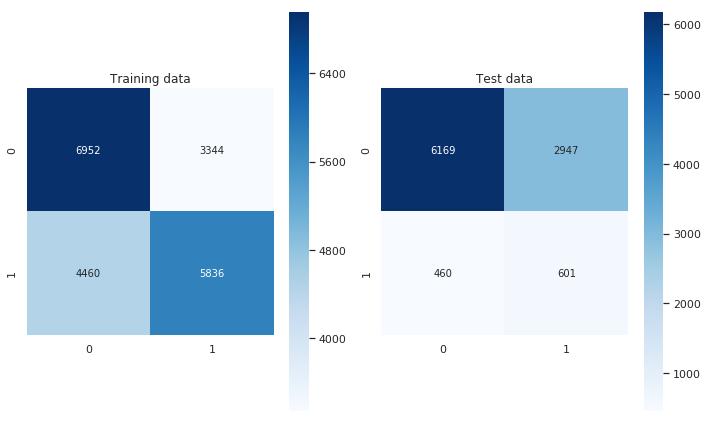

In [74]:
gbc_final = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=2,
    min_samples_split=2,
    max_features=20,
    random_state=42)
gbc_final.fit(X_rus_combined2, y_rus_combined2)
test_model(X_rus_combined2, y_rus_combined2, X_hold3, y_hold3, gbc_final, test='Test')

In [62]:
important_features_final = pd.DataFrame({
    'feature': cols,
    'importance': gbc_final.feature_importances_,
})
important_features_final.loc[important_features_final.importance != 0].sort_values('importance', ascending=False)[:10]

,feature,importance
13,number_inpatient,0.463269
4,discharge_disposition_id,0.251501
12,number_emergency,0.043331
6,time_in_hospital,0.031219
2,age,0.019627
35,insulin,0.015992
15,diag_2,0.013923
42,diabetesMed,0.013705
10,num_medications,0.013218
14,diag_1,0.011147


The important features that played a role in the prediction whether the patient will be readmitted within the 30 days following hospital discharge are number of inpatient visits in a year preceding the encounter, discharge disposition, number of emergency visits in a year preceding the encounter, duration of hospital stay, age. <br>

The F1 score of the final model on the test data is about 0.26. The precision score (the fraction of true positive observation out of the total predicted positive) is about 0.17. The recall score (the fraction of true positive observations out of total true positive) is about 0.57. The model's precision score still is very low, and the model is still overfitting. There are 2 main takeaways from this: 
    1) Use the model as is. Only 17% of the predicted positive are true positive, but the model still allows to narrow down the number of patients that would benefit from the follow up program aimed at minimazing the chances of readmission. This might still lead to significant reduction in the 30 day readmission rates.
    2) Collect more data and build a better model. More data with more features would allow to build a model with much better predictive metrics.
    
The model will be saved on the hard disk for future use.

In [60]:
# save the model to disk
filename = 'finalized_model.pkl'
joblib.dump(gbc_final, filename)

['finalized_model.pkl']